## Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install bioinfokit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import time
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from graphviz import Source

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (MinMaxScaler, StandardScaler, RobustScaler)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
import lightgbm as lgb
from sklearn import tree, ensemble
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
    classification_report
)

In [ ]:
sns.set_theme(style="white", palette='Greens_r', font='serif')

In [ ]:
df = pd.read_feather("/content/drive/MyDrive/Capstone Project/04 Deliverables/04 Data/client_churn.feather")
rfm = pd.read_feather("/content/drive/MyDrive/Capstone Project/04 Deliverables/04 Data/rfm.feather")
past_churn = pd.read_feather("/content/drive/MyDrive/Capstone Project/04 Deliverables/04 Data/past_churn.feather")

## Data handling

In [ ]:
df = df.merge(rfm, on='client_id', how='left')
df = df.merge(past_churn, on='client_id', how='left')

In [ ]:
df.dtypes

client_id           uint64
churn                int64
branch_id            int64
recency              int64
frequency          float64
R_score              int64
F_score              int64
M_score              int64
RFM_group           object
RFM_score            int64
monetary_scaled    float64
at_the_store         int64
phone                int64
sales_rep            int64
online               int64
other                int64
past_churn         float64
dtype: object

In [ ]:
df['RFM_group'] = df['RFM_group'].astype('str') 

In [ ]:
df.shape

(166521, 17)

In [ ]:
df.drop(columns=["client_id","branch_id"], inplace=True)

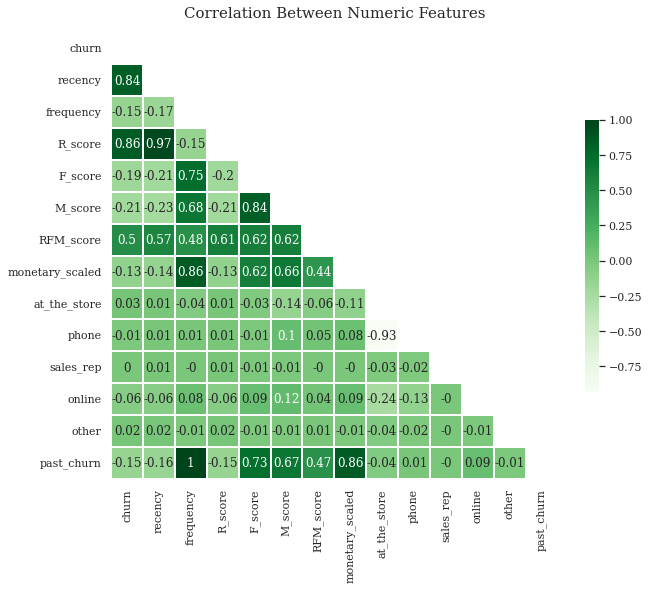

In [ ]:
# Plotting correlation of numerical features as a heatmap

# Getting correlation values for numerical features
corr = round(df.corr(), 2)

# Plotting correlations as a heatmap
fig, ax = plt.subplots(figsize=(10,10))


# Generating a mask so that the only one half of the square has values
mask = np.triu(np.ones_like(corr, dtype=bool))

# Draw the heatmap with the mask and correct aspect ratio
graph = sns.heatmap(corr, annot=True, mask = mask, 
                    square=True, linewidths=1, cbar_kws={"shrink": .5}, cmap="Greens")

# Adding title to figure
graph.set_title("Correlation Between Numeric Features", fontsize = 15, pad = 15)
plt.show()

## Define functions

In [ ]:
# Defining evaluation function

def evaluation(model_or_pipe, y_train, y_test,model_name):  
    
    #Creating empty list to store model evaluation result 
    model_result = []
    
    # Predict on test data
    y_test_prediction = model_or_pipe.predict(X_test)

    # Predict on train data
    X_test_prediction = model_or_pipe.predict(X_train)
    
    # Evaluating model with classification report and confusion matrix
    acc_test = accuracy_score(y_test, y_test_prediction)
    acc_train = accuracy_score(y_train, X_test_prediction)
    precision = precision_score(y_test, y_test_prediction, average = 'macro')
    recall = recall_score(y_test, y_test_prediction, average = 'macro')
    f1 = f1_score(y_test, y_test_prediction, average = 'macro')
    cm = confusion_matrix(y_test, y_test_prediction) 

    #Storing results in list as key - value pairs
    model_result.append({
    "model": model_name,
    "train_accuracy": acc_train,
    "test_accuracy": acc_test, 
    "precision": precision,
    "recall":recall,
    "f1": f1
    })
    
    # Converting dictionary to dataframe
    accuracy_score_df = pd.DataFrame(model_result).set_index("model")

    
    # Plotting confusion matrix
    cmn = cm.astype('float') / cm.sum()
    plt.figure(figsize=(8,8))
    sns.heatmap(cmn, annot=True, square=True, linewidths=1, cbar_kws={"shrink": .5}, cmap="Greens")
    plt.title(f"{model_name} \n Confusion Matrix", 
          size = 20, 
          pad = 15)
    plt.ylabel("Observed", size = 18, labelpad = 13)
    plt.axes().set_xticklabels(['No churn', 'Churn'])
    plt.xlabel("Predicted", size = 18, labelpad = 13)
    plt.axes().set_yticklabels(['No churn','Churn'])
    plt.show()
    
    # Printing dataframe with model evaluation metrics
    return accuracy_score_df

In [ ]:
# Defining evaluation function for scaled data

def evaluation_scaled(model_or_pipe, y_train, y_test,model_name):  
    
    #Creating empty list to store model evaluation result 
    model_result = []
    
    # Predict on test data
    y_test_prediction = model_or_pipe.predict(X_test_remerged)

    # Predict on train data
    X_test_prediction = model_or_pipe.predict(X_train_remerged)
    
    # Evaluating model with classification report and confusion matrix
    acc_test = accuracy_score(y_test, y_test_prediction)
    acc_train = accuracy_score(y_train, X_test_prediction)
    precision = precision_score(y_test, y_test_prediction, average = 'macro')
    recall = recall_score(y_test, y_test_prediction, average = 'macro')
    f1 = f1_score(y_test, y_test_prediction, average = 'macro')
    cm = confusion_matrix(y_test, y_test_prediction) 

    #Storing results in list as key - value pairs
    model_result.append({
    "model": model_name,
    "train_accuracy": acc_train,
    "test_accuracy": acc_test, 
    "precision": precision,
    "recall":recall,
    "f1": f1
    })
    
    # Converting dictionary to dataframe
    accuracy_score_df = pd.DataFrame(model_result).set_index("model")

    
    # Plotting confusion matrix
    cmn = cm.astype('float') / cm.sum()
    plt.figure(figsize=(8,8))
    sns.heatmap(cmn, annot=True, square=True, linewidths=1, cbar_kws={"shrink": .5}, cmap="Greens")
    plt.title(f"{model_name} \n Confusion Matrix", 
          size = 20, 
          pad = 15)
    plt.ylabel("Observed", size = 18, labelpad = 13)
    plt.axes().set_xticklabels(['No churn', 'Churn'])
    plt.xlabel("Predicted", size = 18, labelpad = 13)
    plt.axes().set_yticklabels(['No churn','Churn'])
    plt.show()
    
    # Printing dataframe with model evaluation metrics
    return accuracy_score_df

In [ ]:
# Defining feature importance function

def feature_importance(model_or_pipe):
    feat_imp = model_or_pipe.feature_importances_
    features = X_train.columns
    feat_imp_dt = pd.DataFrame({
        "feature": features, 
        "importance": feat_imp
    }).sort_values(by="importance", ascending=False).reset_index(drop=True)

    return feat_imp_dt

In [ ]:
def plot_feature_importance(importance,names,model_type):

  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

  #Define size of bar plot
  plt.figure(figsize=(10,8))
  #Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], color="forestgreen")
  #Add chart labels
  plt.title(model_type + 'FEATURE IMPORTANCE', fontsize=16)
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')

## Split data

In [ ]:
# Defining target and predictors
y = df['churn']
X = df.drop('churn', axis=1)

# separate train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.head()

,recency,frequency,R_score,F_score,M_score,RFM_group,RFM_score,monetary_scaled,at_the_store,phone,sales_rep,online,other,past_churn
6689,241,8.0,2,1,1,211,4,0.000052,1,0,0,0,0,1.0
161539,20,151.0,1,1,1,111,3,0.001502,0,1,0,0,0,40.0
37360,20,71.0,1,1,1,111,3,0.001299,0,1,0,0,0,16.0
161149,487,2.0,3,1,1,311,5,0.000051,1,0,0,0,0,0.0
10095,398,68.0,3,1,1,311,5,0.000122,1,0,0,0,0,15.0


In [ ]:
numeric_train = X_train[["recency","frequency","past_churn"]]
rest_train = X_train.drop(columns = ["recency","frequency","past_churn"])

numeric_test = X_test[["recency","frequency","past_churn"]]
rest_test = X_test.drop(columns = ["recency","frequency","past_churn"])

## Baseline model with feature importances

In [ ]:
#Defining model to use and model name
model_0 = tree.DecisionTreeClassifier(random_state = 42)
model_0_name = "Decision Tree Classifier"

In [ ]:
# Fitting model 
model_0.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


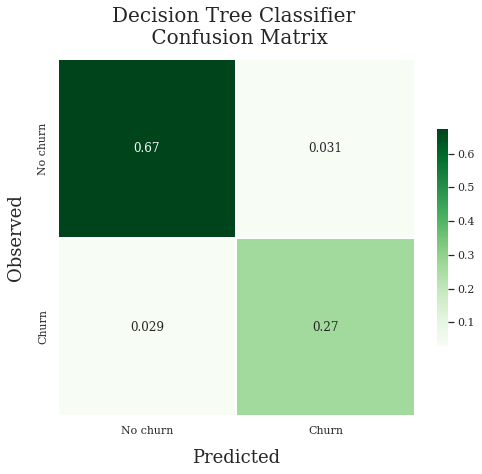

,train_accuracy,test_accuracy,precision,recall,f1
model,,,,,
Decision Tree Classifier,0.99994,0.9407,0.928179,0.93,0.929082


In [ ]:
# Printing model performance
evaluation(model_0, y_train, y_test, model_0_name)

In [ ]:
# Calculating feature importance
feature_importance1 = feature_importance(model_0)
feature_importance1

,feature,importance
0,recency,0.852826
1,monetary_scaled,0.084353
2,frequency,0.035054
3,past_churn,0.020775
4,phone,0.003091
5,at_the_store,0.002586
6,online,0.000659
7,RFM_group,0.000269
8,RFM_score,0.000150
9,R_score,0.000139


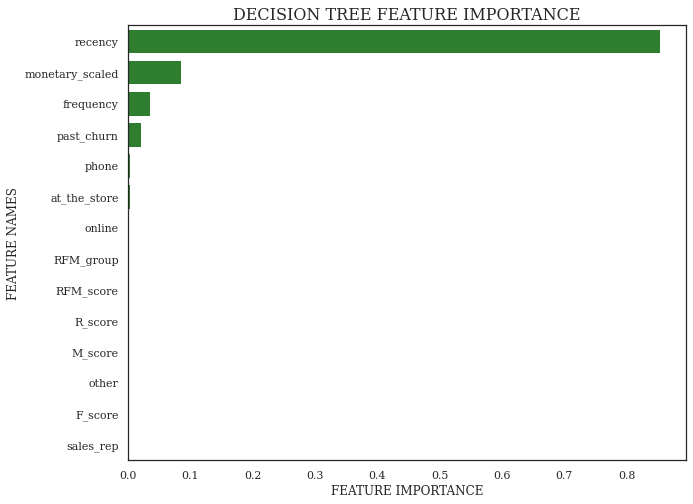

In [ ]:
plot_feature_importance(model_0.feature_importances_,X_train.columns,
                        'DECISION TREE ')

## Decision Tree with scaled numeric data

In [ ]:
# Defining pipeline with column transformations 
pipeline = Pipeline([
    ("scaler", RobustScaler()),
    ("power transformer", PowerTransformer()),
])

# Fitting pipeline to x_train numerical features
x_train_scaled = pipeline.fit_transform(numeric_train)

x_train_scaled_data = pd.DataFrame(x_train_scaled, columns = numeric_train.columns)

# Passing new Index
x_train_scaled_data["index"] = range(1, 1 + len(x_train_scaled_data))
rest_train["index"] = range(1, 1 + len(rest_train))

x_train_scaled_data.set_index("index", inplace = True)
rest_train.set_index("index", inplace = True)

# same for testset
x_test_scaled = pipeline.fit_transform(numeric_test)

x_test_scaled_data = pd.DataFrame(x_test_scaled, columns = numeric_test.columns)

# Passing new Index
x_test_scaled_data["index"] = range(1, 1 + len(x_test_scaled_data))
rest_test["index"] = range(1, 1 + len(rest_test))

x_test_scaled_data.set_index("index", inplace = True)
rest_test.set_index("index", inplace = True)

In [ ]:
X_train_remerged = x_train_scaled_data.merge(rest_train, left_index=True, right_index = True)
X_test_remerged = x_test_scaled_data.merge(rest_test, left_index=True, right_index = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


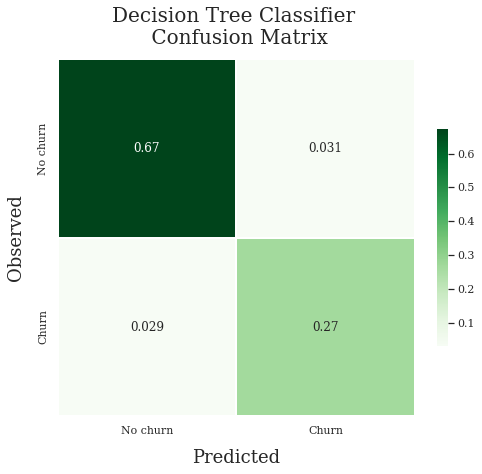

,train_accuracy,test_accuracy,precision,recall,f1
model,,,,,
Decision Tree Classifier,0.99994,0.940099,0.927665,0.928987,0.928322


In [ ]:
model_0.fit(X_train_remerged, y_train)

# Printing model performance
evaluation_scaled(model_0, y_train, y_test, model_0_name)

## PCA

In [ ]:
pca = PCA()

In [ ]:
# Defining pipeline with pca and Decision Tree Classifier
pca_pipeline = Pipeline([
    ("pca", pca),
    ("model", tree.DecisionTreeClassifier()),
])

In [ ]:
# fit pipeline
pca.fit_transform(x_train_scaled_data)

model_2_name = "Decision Tree Classifier with PCA"

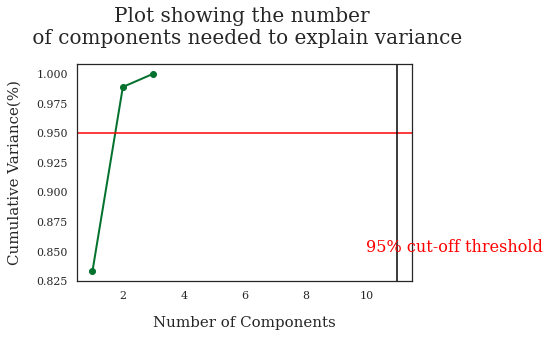

In [ ]:
#Plotting cumulative variance
cumsum = np.cumsum(pca.explained_variance_ratio_)


PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, cumsum, 'o-', linewidth=2)
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(10, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)
plt.axvline(x = 11, color='black', linestyle='-')
plt.title('Plot showing the number \n of components needed to explain variance', fontsize = 20, pad = 20)
plt.xlabel('Number of Components', fontsize = 15, labelpad = 15)
plt.ylabel("Cumulative Variance(%)", fontsize = 15, labelpad = 15)
plt.show()

## Changing our Model - Algorithm

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


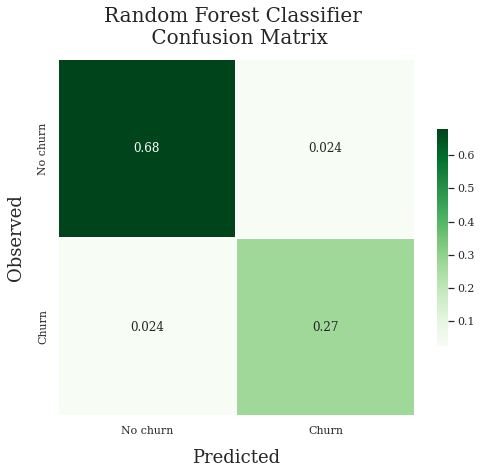

,train_accuracy,test_accuracy,precision,recall,f1
model,,,,,
Random Forest Classifier,0.999932,0.951599,0.941881,0.94214,0.94201


In [ ]:
#Defining model to use and model name
model_2 = RandomForestClassifier(random_state = 42)
model_2_name = "Random Forest Classifier"

# Fitting model 
model_2.fit(X_train, y_train)

# Printing model performance
evaluation(model_2, y_train, y_test, model_2_name)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


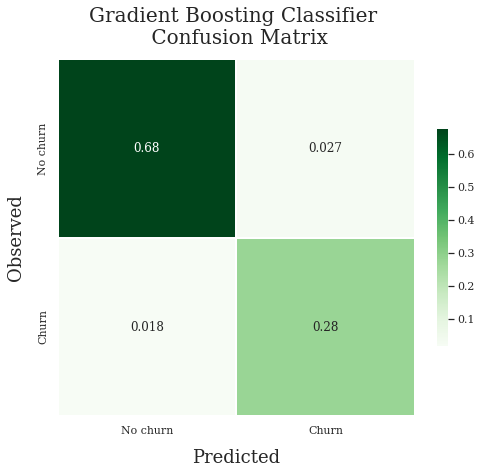

,train_accuracy,test_accuracy,precision,recall,f1
model,,,,,
Gradient Boosting Classifier,0.954352,0.954271,0.942004,0.949574,0.945666


In [ ]:
#Defining model to use and model name
model_3 = GradientBoostingClassifier(random_state = 42)
model_3_name = "Gradient Boosting Classifier"

# Fitting model 
model_3.fit(X_train, y_train)

# Printing model performance
evaluation(model_3, y_train, y_test, model_3_name)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the sa

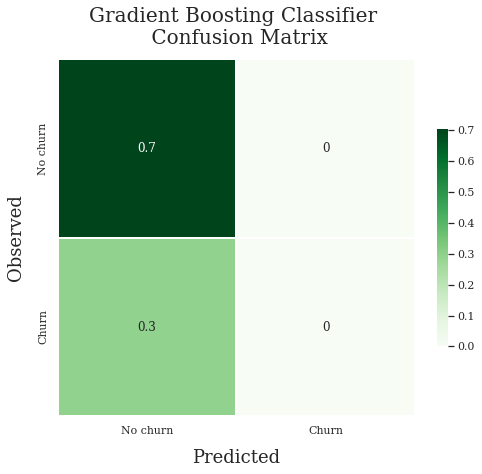

,train_accuracy,test_accuracy,precision,recall,f1
model,,,,,
Gradient Boosting Classifier,0.703677,0.703468,0.351734,0.5,0.412962


In [ ]:
# Printing model performance scaled data
evaluation_scaled(model_3, y_train, y_test, model_3_name)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


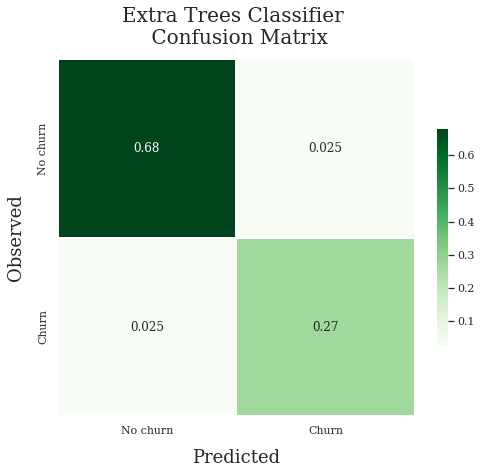

,train_accuracy,test_accuracy,precision,recall,f1
model,,,,,
Extra Trees Classifier,0.999985,0.950398,0.940531,0.940583,0.940557


In [ ]:
#Defining model to use and model name
model_4 = ExtraTreesClassifier(random_state = 42)
model_4_name = "Extra Trees Classifier"

# Fitting model 
model_4.fit(X_train, y_train)

# Printing model performance
evaluation(model_4, y_train, y_test, model_4_name)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


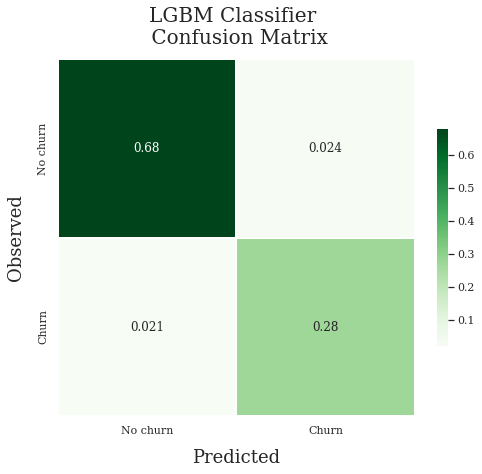

,train_accuracy,test_accuracy,precision,recall,f1
model,,,,,
LGBM Classifier,0.957377,0.955262,0.945303,0.947789,0.946533


In [ ]:
X_train_l = X_train.drop(columns="RFM_group")
X_test_l = X_test.drop(columns="RFM_group")

#Defining model to use and model name
model_4 = lgb.LGBMClassifier(objective = "binary", random_state = 42)
model_4_name = "LGBM Classifier"

# Fitting model 
model_4.fit(X_train_l, y_train)

# Printing model performance
model_result = []

# Predict on test data
y_test_prediction = model_4.predict(X_test_l)

# Predict on train data
X_test_prediction = model_4.predict(X_train_l)

# Evaluating model with classification report and confusion matrix
acc_test = accuracy_score(y_test, y_test_prediction)
acc_train = accuracy_score(y_train, X_test_prediction)
precision = precision_score(y_test, y_test_prediction, average = 'macro')
recall = recall_score(y_test, y_test_prediction, average = 'macro')
f1 = f1_score(y_test, y_test_prediction, average = 'macro')
cm = confusion_matrix(y_test, y_test_prediction) 

#Storing results in list as key - value pairs
model_result.append({
"model": model_4_name,
"train_accuracy": acc_train,
"test_accuracy": acc_test, 
"precision": precision,
"recall":recall,
"f1": f1
})

# Converting dictionary to dataframe
accuracy_score_df = pd.DataFrame(model_result).set_index("model")

# Plotting confusion matrix
cmn = cm.astype('float') / cm.sum()
plt.figure(figsize=(8,8))
sns.heatmap(cmn, annot=True, square=True, linewidths=1, cbar_kws={"shrink": .5}, cmap="Greens")
plt.title(f"{model_4_name} \n Confusion Matrix", size = 20, pad = 15)
plt.ylabel("Observed", size = 18, labelpad = 13)
plt.axes().set_xticklabels(['No churn', 'Churn'])
plt.xlabel("Predicted", size = 18, labelpad = 13)
plt.axes().set_yticklabels(['No churn','Churn'])
plt.show()

accuracy_score_df

## SMOTE

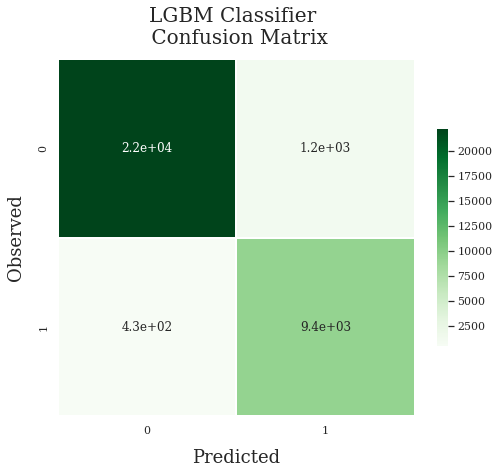

,train_accuracy,test_accuracy,precision,recall,f1
model,,,,,
LGBM Classifier,0.964226,0.951869,0.935245,0.953285,0.943522


In [ ]:
oversample = SMOTE()
X_sm, y_sm = oversample.fit_resample(X_train, y_train)
X_train_ls = X_sm.drop(columns="RFM_group")

# Fitting model 
model_4.fit(X_train_ls, y_sm)

# Printing model performance
model_result = []

# Predict on test data
y_test_prediction = model_4.predict(X_test_l)

# Predict on train data
X_test_prediction = model_4.predict(X_train_ls)

# Evaluating model with classification report and confusion matrix
acc_test = accuracy_score(y_test, y_test_prediction)
acc_train = accuracy_score(y_sm, X_test_prediction)
precision = precision_score(y_test, y_test_prediction, average = 'macro')
recall = recall_score(y_test, y_test_prediction, average = 'macro')
f1 = f1_score(y_test, y_test_prediction, average = 'macro')
cm = confusion_matrix(y_test, y_test_prediction) 

#Storing results in list as key - value pairs
model_result.append({
"model": model_4_name,
"train_accuracy": acc_train,
"test_accuracy": acc_test, 
"precision": precision,
"recall":recall,
"f1": f1
})

# Converting dictionary to dataframe
accuracy_score_df = pd.DataFrame(model_result).set_index("model")

# Plotting confusion matrix
cm_df = pd.DataFrame(cm, 
                  index = [0,1], 
                  columns = [0,1])
plt.figure(figsize=(8,8))
sns.heatmap(cm_df, annot=True, square=True, linewidths=1, cbar_kws={"shrink": .5}, cmap="Greens")
plt.title(f"{model_4_name} \n Confusion Matrix", 
      size = 20, 
      pad = 15)
plt.ylabel("Observed", size = 18, labelpad = 13)
plt.xlabel("Predicted", size = 18, labelpad = 13)
plt.show()

accuracy_score_df

## Wrong predictions analysis for best model (LGBM)

In [ ]:
y_test_prediction = model_4.predict(X_test_l)

wrongs = y_test != y_test_prediction
wrongcs = X_test[wrongs]

correct = (y_test == y_test_prediction)
correctcs = X_test[correct]

In [ ]:
means_wr = pd.DataFrame(wrongcs.describe().iloc[1,:])
means_cor = pd.DataFrame(correctcs.describe().iloc[1,:])
means_wr.rename(columns={"mean":"mean_wrong"}, inplace=True)
means_cor.rename(columns={"mean":"mean_correct"}, inplace=True)

mix = pd.concat([means_wr, means_cor], axis=1)
mix

,mean_wrong,mean_correct
recency,183.402994,144.788215
frequency,63.343731,407.511482
R_score,2.023082,1.594347
F_score,1.011853,1.157845
M_score,1.019339,1.183837
RFM_score,4.054273,3.936029
monetary_scaled,0.000380,0.002199
at_the_store,0.645041,0.628762
phone,0.333125,0.337077
sales_rep,0.001248,0.000599
